In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline


Bad key text.latex.preview in file matplotlibrc, line 10 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%autoreload

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import copy
import pickle
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d

import darkhistory.physics as phys
from darkhistory.history.tla import get_history

import main
import config

In [4]:
import darkhistory.history.reionization as reion
import csv

reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late','FlexKnot_early_1sig', 'FlexKnot_late_1sig', 'Tanh_early', 'Tanh_late', 'Tanh_early_1sig', 'Tanh_late_1sig']
)

def make_reion_interp_func(string, He_bump=False):
    Planck_data = []
    with open('/home/zixuan/DarkHistory-T_igm/examples/Planck_reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)

    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]
        
        #I WebPlot Digitized poorly, so I re-zero
        if string == 'FlexKnot_late':
            Planck_data[26:,1] = 0
        elif string == 'Tanh_late':
            Planck_data[63:,1] = 0
            
        
    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac

    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]

    fac = 2
    if He_bump == False:
        Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
        fac = 1

    return interp1d(Planck_data[:,0], Planck_data[:,1], 
                    bounds_error=False, fill_value=(1+fac*phys.chi,0), kind='linear')

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
bump_interp = make_reion_interp_func('Tanh_late', True)

# Plot the different methods
reion_rs_list = 10**np.arange(0,np.log10(25), .01)
colors = {'FlexKnot_early': 'C0',
         'FlexKnot_late': 'C0',
         'FlexKnot_early_1sig': 'C0',
         'FlexKnot_late_1sig': 'C0',
         'Tanh_early': 'k',
         'Tanh_late': 'k',
         'Tanh_early_1sig': 'k',
         'Tanh_late_1sig': 'k'}

In [5]:
# List of redshifts, Average Temperatures, and error bars
z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[-7:]

new_mids=np.array([.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599])
mids = new_mids[-7:]

high_errs = np.array([.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15])
low_errs  = np.array([.22,.091,.15,.19,.14,.15,.14,.12,.16,.27,.19,.17,.073,.11,.091,.13])
sigs = high_errs[-7:]

Gaikwad_data = np.array([[1.1, .16], [1.05, .21], [1.2, .22]])
Gaikwad_rs   = np.array([6.4,6.6,6.8])

# Fiducial Data
default_data = [
    np.concatenate((rs_entries[:-2], Gaikwad_rs)),
    (
        np.concatenate((mids[:-2], Gaikwad_data[:,0])),
        np.concatenate((sigs[:-2], Gaikwad_data[:,1]))
    )
]

In [6]:
mDM = 1e6
sigmav= 3.918e-37
DM_process='swave'
struct_boost = phys.struct_boost_func(model='einasto_subs')

FlexLate_hist_swave_1MeV = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, sigmav=sigmav,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_late'],
    start_rs = 3e3, end_rs=4.3,alpha_bk=.57,DeltaT=24665*phys.kB,
    heat_switch=True,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=struct_boost
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


  0%|          | 0/546.0 [00:00<?, ?it/s]

/home/zixuan/anaconda3/envs/dm21cm-ann/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [7]:
mDM = 2e6
sigmav = 6.048e-38
DM_process='swave'
struct_boost = phys.struct_boost_func(model='einasto_subs')

FlexLate_hist_swave_2MeV = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, sigmav=sigmav,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_late'],
    start_rs = 3e3, end_rs=4.3,alpha_bk=.57,DeltaT=24665*phys.kB,
    heat_switch=True,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=struct_boost
)

  0%|          | 0/546.0 [00:00<?, ?it/s]

In [8]:
mDM = 4e6
sigmav = 1.264e-38
DM_process='swave'
struct_boost = phys.struct_boost_func(model='einasto_subs')

FlexLate_hist_swave_4MeV = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, mDM=mDM, sigmav=sigmav,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_late'],
    start_rs = 3e3, end_rs=4.3,alpha_bk=.57,DeltaT=24665*phys.kB,
    heat_switch=True,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=struct_boost
)

  0%|          | 0/546.0 [00:00<?, ?it/s]

In [9]:
histFL = main.evolve(
    primary='elec_delta',
    DM_process=DM_process, 
    mDM=1e9, 
    sigmav=1e-200,
    struct_boost = phys.struct_boost_func(model='einasto_subs'),
    reion_switch=True, reion_rs=35, 
    helium_TLA=True,
    xe_reion_func = reion_interps['FlexKnot_late'],
    start_rs = 3e3, end_rs=4.3,alpha_bk=.57,DeltaT=24665*phys.kB,
    heat_switch=True,
    coarsen_factor=12, 
    backreaction=True, 
    compute_fs_method='He', 
    mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False
)

  0%|          | 0/546.0 [00:00<?, ?it/s]

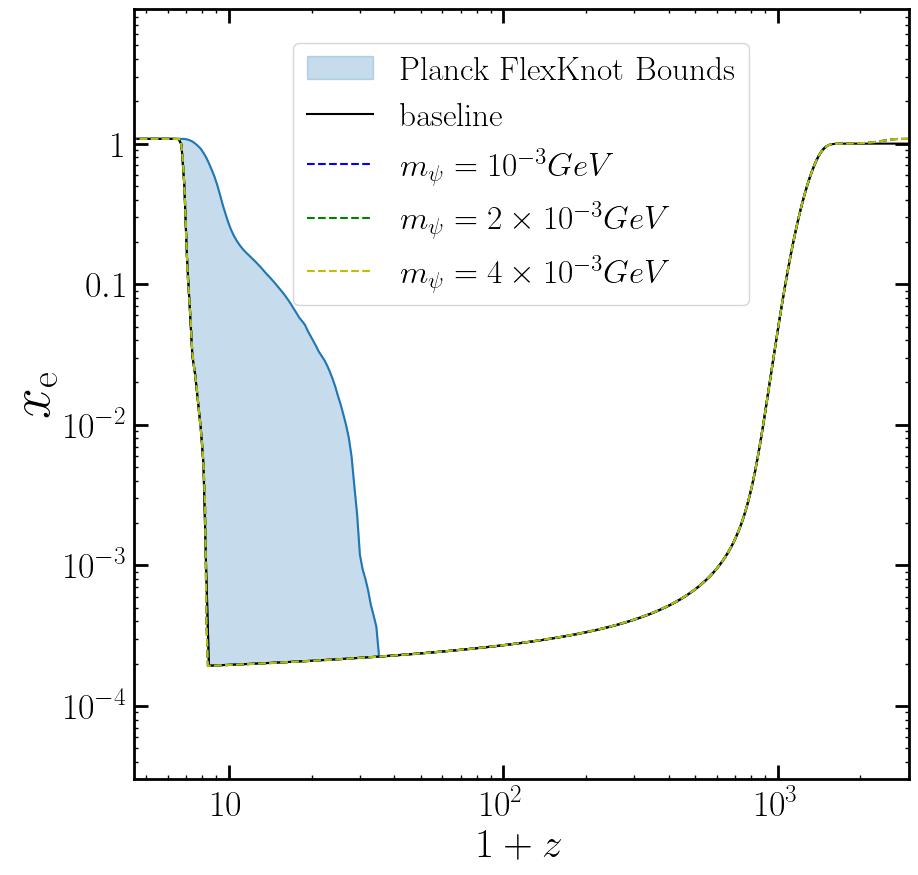

In [11]:
#%autoreload
fig0, axarr0 = plt.subplots(figsize=(10,10))

axarr0.loglog()
axarr0.axis([4.5,3e3,3e-5,9])

rs_list0 = 10**np.arange(np.log10(3e3)-.0001, np.log10(4.01), -.01)
history0 = get_history(rs_list0, helium_TLA=True)[1]

DeltaT=24665*phys.kB
alpha_bk = .57
histFE_base = get_history(
     rs_list0, 
     heat_switch = True, 
     DeltaT = DeltaT, alpha_bk = alpha_bk,
     reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_early']
)[1]
histFL_base = get_history(
     rs_list0, 
     heat_switch = True, 
     DeltaT = DeltaT, alpha_bk = alpha_bk,
     reion_switch = True, reion_rs = 35, xe_reion_func = reion_interps['FlexKnot_late']
 )[1]

axarr0.plot(rs_list0[30:], histFE_base[30:,1]+histFE_base[30:,2], color='C0', linewidth=1.5)
axarr0.plot(rs_list0[30:], histFL_base[30:,1]+histFL_base[30:,2], color='C0', linewidth=1.5)

axarr0.fill_between(rs_list0[30:], 
 histFL_base[30:,1]+histFL_base[30:,2],
 histFE_base[30:,1]+histFE_base[30:,2],
 color='C0',
 alpha=0.25, label='Planck FlexKnot Bounds')

axarr0.plot(rs_list0, histFL_base[:,1]+histFL_base[:,2], color='k', linewidth=1.5, label='baseline')

axarr0.plot(FlexLate_hist_swave_1MeV['rs'], FlexLate_hist_swave_1MeV['x'][:,0]+FlexLate_hist_swave_1MeV['x'][:,1], 
              color='b', linewidth=1.5, label=r'$m_\psi=10^{-3}GeV$', linestyle='--')
axarr0.plot(FlexLate_hist_swave_2MeV['rs'], FlexLate_hist_swave_2MeV['x'][:,0]+FlexLate_hist_swave_2MeV['x'][:,1], 
              color='g', linewidth=1.5, label=r'$m_\psi=2\times10^{-3}GeV$', linestyle='--')
axarr0.plot(FlexLate_hist_swave_4MeV['rs'], FlexLate_hist_swave_4MeV['x'][:,0]+FlexLate_hist_swave_4MeV['x'][:,1], 
              color='y', linewidth=1.5, label=r'$m_\psi=4\times10^{-3}GeV$', linestyle='--')

axarr0.set_xlabel(r'$1+z$', fontsize=30)
axarr0.set_ylabel(r'$x_\mathrm{e}$', fontsize=40)
axarr0.legend(fontsize=24)

for tick in axarr0.xaxis.get_major_ticks():
    tick.label.set_fontsize(26)
for tick in axarr0.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
    
plt.show()

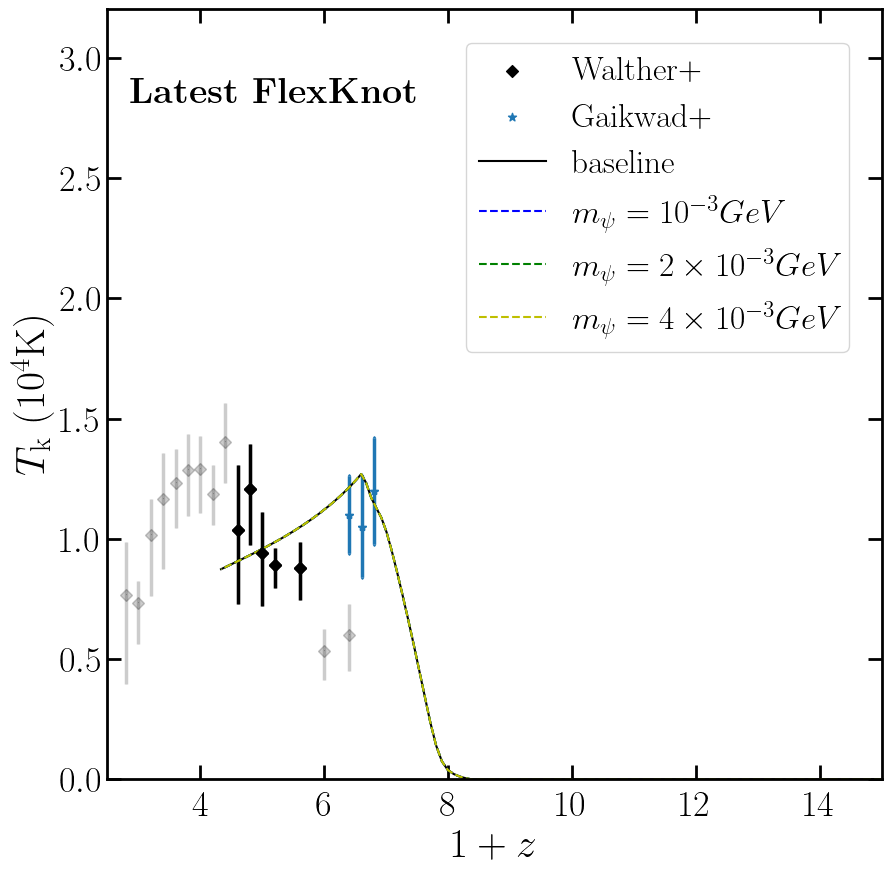

In [12]:
fig1, axarr1 = plt.subplots(figsize=(10,10))
axarr1.axis([2.5,15,0,3.2])
plt_ind = -7
plotline1, cap1, barlinecols1 = axarr1.errorbar(1+z_entries, new_mids, yerr=high_errs, 
             uplims=True, fmt='D', alpha=0.2, color='k', capsize=0.1, capthick=0.1)
plotline2, cap2, barlinecols2 = axarr1.errorbar(1+z_entries, new_mids, yerr=low_errs,  
             lolims=True, fmt=',', alpha=0.2, color='k', capsize=0.1, capthick=0.1)

plotline3, cap3, barlinecols3 = axarr1.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2], yerr=high_errs[plt_ind:-2], 
             uplims=True, fmt='D', color='k', capsize=0.1, capthick=0.1)
plotline4, cap4, barlinecols4 = axarr1.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2], yerr=low_errs[plt_ind:-2],  
             lolims=True, fmt=',', color='k', capsize=0.1, capthick=0.1)
axarr1.scatter(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2],  
             marker='D', color='k', label='Walther+')

plotlineG1, cap2, barlinecols2 = axarr1.errorbar(Gaikwad_rs, Gaikwad_data[:,0], yerr=Gaikwad_data[:,1],  
             lolims=True, fmt='*', color='C0', capsize=0.9, capthick=0.9)
plotlineG1, cap2, barlinecols2 = axarr1.errorbar(Gaikwad_rs, Gaikwad_data[:,0], yerr=Gaikwad_data[:,1],  
             uplims=True, fmt='*', color='C0', capsize=0.9, capthick=0.9)
axarr1.scatter(Gaikwad_rs, Gaikwad_data[:,0]*1e4,  
             marker='*', color='C0', label='Gaikwad+')

norm = 1e-4/phys.kB

axarr1.plot(histFL['rs'], histFL['Tm']*norm, color='k',linewidth=1.5, label="baseline")

axarr1.set_xlabel(r'$1+z$', fontsize=30)
axarr1.set_ylabel(r'$T_\mathrm{k}$ ($10^4$K)', fontsize=30)

axarr1.plot(FlexLate_hist_swave_1MeV['rs'], FlexLate_hist_swave_1MeV['Tm']*norm, color='b', linewidth=1.5, linestyle='--',
              label=r'$m_\psi=10^{-3}GeV$')
axarr1.plot(FlexLate_hist_swave_2MeV['rs'], FlexLate_hist_swave_2MeV['Tm']*norm, color='g', linewidth=1.5, linestyle='--',
              label=r'$m_\psi=2\times10^{-3}GeV$')
axarr1.plot(FlexLate_hist_swave_4MeV['rs'], FlexLate_hist_swave_4MeV['Tm']*norm, color='y', linewidth=1.5, linestyle='--',
              label=r'$m_\psi=4\times10^{-3}GeV$')

axarr1.legend(fontsize=24)

axarr1.text(5.2, 2.85, '$\\textbf{Latest\ FlexKnot}$',
    {'color': 'black', 'fontsize': 26, 'ha': 'center', 'va': 'center'})

for tick in axarr1.xaxis.get_major_ticks():
    tick.label.set_fontsize(26)
for tick in axarr1.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)
    
plt.show()

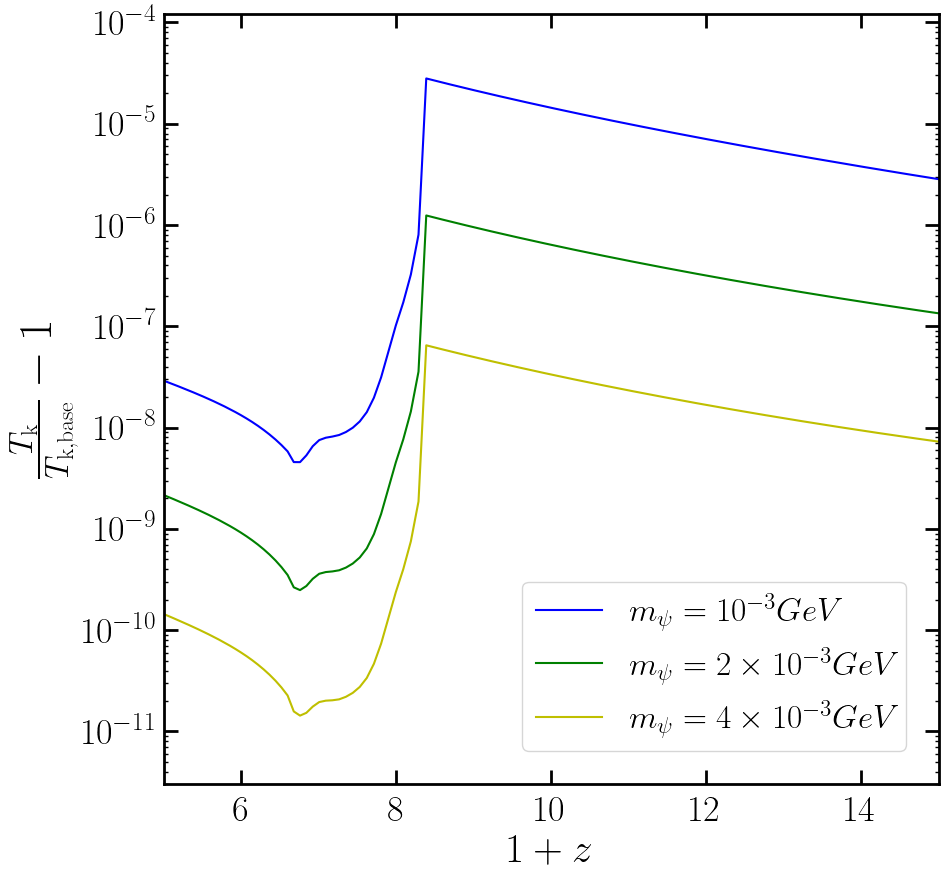

In [13]:
fig2, axarr2 = plt.subplots(figsize=(10,10))
axarr2.set_xlim(5,15)
axarr2.set_yscale('log')
axarr2.set_ylim(3e-12,1.2e-4)
baseline = histFL['Tm'] * (1e-4 / phys.kB)

data_list = [FlexLate_hist_swave_1MeV, 
             FlexLate_hist_swave_2MeV,
             FlexLate_hist_swave_4MeV
            ]
color_list = ['b', 
              'g',
              'y'
             ]
label_list = [r'$m_\psi=10^{-3}GeV$', 
              r'$m_\psi=2\times10^{-3}GeV$',
              r'$m_\psi=4\times10^{-3}GeV$'
             ]

for data, color, label in zip(data_list, color_list, label_list):
    axarr2.plot(data['rs'], (data['Tm'] * (1e-4 / phys.kB) / baseline) - 1, linewidth=1.5, color=color, label=label)

axarr2.legend(fontsize=24)
axarr2.set_xlabel(r'$1+z$', fontsize=30)
axarr2.set_ylabel(r'$\frac{T_\mathrm{k}}{T_\mathrm{k,base}}-1$', fontsize=34)

for tick in axarr2.xaxis.get_major_ticks():
    tick.label.set_fontsize(26)
for tick in axarr2.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)

plt.show()

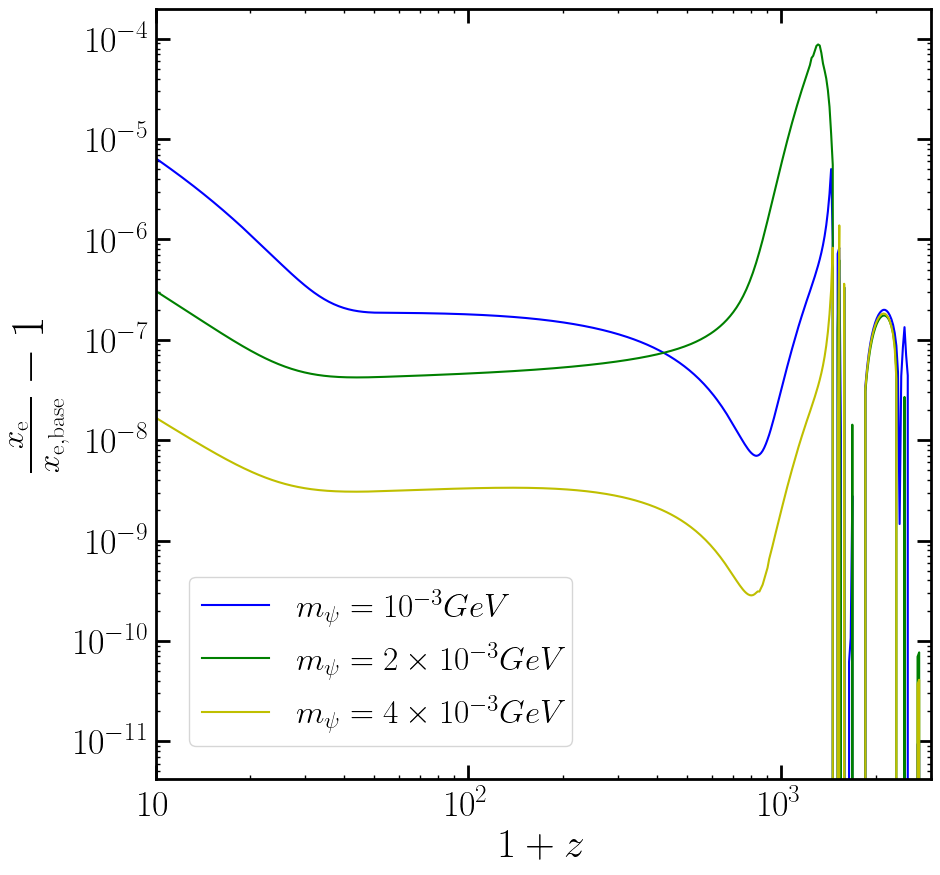

In [14]:
fig3, axarr3 = plt.subplots(figsize=(10,10))
axarr3.set_xlim(10,3e3)
axarr3.loglog()
baseline2 = (histFL['x'][:, 0]+histFL['x'][:, 1])

data_list = [FlexLate_hist_swave_1MeV, 
             FlexLate_hist_swave_2MeV, 
             FlexLate_hist_swave_4MeV
            ]
color_list = ['b', 
              'g', 
              'y'
             ]
label_list = [r'$m_\psi=10^{-3}GeV$', 
              r'$m_\psi=2\times10^{-3}GeV$', 
              r'$m_\psi=4\times10^{-3}GeV$'
             ]

for data, color, label in zip(data_list, color_list, label_list):
    axarr3.plot(data['rs'], ((data['x'][:,0]+data['x'][:,1])/ baseline2) - 1, color=color, linewidth=1.5, label=label)

axarr3.legend(fontsize=24)
axarr3.set_xlabel(r'$1+z$', fontsize=30)
axarr3.set_ylabel(r'$\frac{x_\mathrm{e}}{x_\mathrm{e,base}}-1$', fontsize=34)

for tick in axarr3.xaxis.get_major_ticks():
    tick.label.set_fontsize(26)
for tick in axarr3.yaxis.get_major_ticks():
    tick.label.set_fontsize(26)

plt.show()